In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image

sess = tf.Session()
tf.keras.backend.set_session(sess)

In [2]:
from keras.models import load_model
model = load_model('killme_vgg16.h5')

Using TensorFlow backend.


In [3]:
model.load_weights('killme_vgg16_weights.h5')

In [4]:
root_dir = 'kill_me_images/kill_me_baby_datasets/'

class_list = sorted(os.listdir(path=root_dir))
print("クラスリスト", class_list)

クラスリスト ['agiri', 'botsu', 'others', 'sonya', 'yasuna', 'yasuna&agiri', 'yasuna&sonya']


In [5]:
def load_imgs(root_dir):    

    print(class_list)
    num_class = len(class_list)
    img_paths = []
    labels = []
    images = []
    for cl_name in class_list:
        img_names = os.listdir(os.path.join(root_dir, cl_name))
        for img_name in img_names:
            img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
            hot_cl_name = get_class_one_hot(cl_name, class_list)
            labels.append(hot_cl_name)

    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    images = np.array(images)

    return np.array(images), np.array(labels), class_list

In [6]:
def get_class_one_hot(class_str, class_list):
    label = class_list.index(class_str)
    label_hot = tf.one_hot(label, len(class_list))
    
    return label_hot

In [7]:
orig_image, orig_label, class_list = load_imgs(root_dir='kill_me_images/kill_me_baby_datasets/')

['agiri', 'botsu', 'others', 'sonya', 'yasuna', 'yasuna&agiri', 'yasuna&sonya']


推論結果のインデックス： 4
推論結果のクラス yasuna


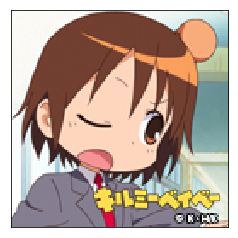

In [8]:
ref_idx = 627

result_num = np.argmax(model.predict(np.expand_dims(orig_image[ref_idx]/255.0, axis=0)))

print("推論結果のインデックス：", result_num)
print("推論結果のクラス", class_list[result_num])
plt.imshow(np.squeeze(orig_image[ref_idx]/255.0))
plt.tick_params(labelbottom=False, labelleft=False, color='white')

推論結果のインデックス： 4
推論結果のクラス yasuna


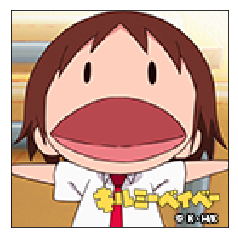

In [9]:
ref_idx = 457

result_num = np.argmax(model.predict(np.expand_dims(orig_image[ref_idx]/255.0, axis=0)))

print("推論結果のインデックス：", result_num)
print("推論結果のクラス", class_list[result_num])
plt.imshow(np.squeeze(orig_image[ref_idx]/255.0))
plt.tick_params(labelbottom=False, labelleft=False, color='white')

推論結果のインデックス： 3
推論結果のクラス sonya


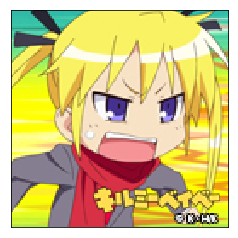

In [10]:
ref_idx = 257

result_num = np.argmax(model.predict(np.expand_dims(orig_image[ref_idx]/255.0, axis=0)))

print("推論結果のインデックス：", result_num)
print("推論結果のクラス", class_list[result_num])
plt.imshow(np.squeeze(orig_image[ref_idx]/255.0))
plt.tick_params(labelbottom=False, labelleft=False, color='white')

推論結果のインデックス： 3
推論結果のクラス sonya


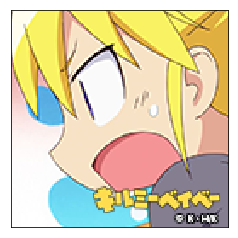

In [11]:
ref_idx = 124

result_num = np.argmax(model.predict(np.expand_dims(orig_image[ref_idx]/255.0, axis=0)))

print("推論結果のインデックス：", result_num)
print("推論結果のクラス", class_list[result_num])
plt.imshow(np.squeeze(orig_image[ref_idx]/255.0))
plt.tick_params(labelbottom=False, labelleft=False, color='white')

In [12]:
graph = tf.get_default_graph()

In [13]:
model.graph = tf.Graph()

In [14]:
y_pred = graph.get_tensor_by_name('model/activation/Softmax:0')
y_logits = graph.get_tensor_by_name('model/logits/BiasAdd:0')
input_img = graph.get_tensor_by_name('input_1:0')

In [17]:
saver.restore(sess, "killme_vgg16/killme_vgg16.ckpt")

INFO:tensorflow:Restoring parameters from killme_vgg16/killme_vgg16.ckpt


In [18]:
with graph.as_default():
    pl_cls_target = tf.placeholder(dtype=tf.int32, name='pl_cls_target')
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target], name='sparse_loss')
    gradient = tf.gradients(loss, input_img, name='adv_gradient')
    
sess = tf.keras.backend.get_session()
saver = tf.train.Saver()
saver.save(sess, "models/killme_vgg16.ckpt")

'models/killme_vgg16.ckpt'

In [19]:
y_pred = 'model/activation/Softmax:0'
y_logits = 'model/logits/BiasAdd:0'
input_img = 'input_1:0'

In [20]:
def find_adversary_noise(image_path, cls_tar, noise_limit=3.0, required_score=0.99, iterations=100, top_k=5):
    
    image = np.array(Image.open(image_path))
    image.flags.writeable = True
    image = np.expand_dims(image, axis=0)
    
    with tf.Session() as sess:
        
        saver.restore(sess, "killme_vgg16/killme_vgg16.ckpt")
        pred = sess.run(y_pred, feed_dict={input_img: image/255.})
        pred = np.squeeze(pred)
        
        # 予測クラスの番号
        cls_source = np.argmax(pred)
        # 予測クラス名
        cls_name_source = class_list[cls_source]
        # ターゲットのクラス名
        cls_name_tar = class_list[cls_tar]        
        # 予測確率
        prob_source = np.max(pred)
        
        # Adversarial Examplesで加えるノイズ
        noise = 0
        
        for i in range(iterations):
            print("イテレーション：", i)
        
            adv_img = image + noise
            adv_img = np.clip(a=adv_img, a_min=0.0, a_max=255.0)
            
            pred, grad = sess.run([y_pred, gradient], feed_dict={input_img: adv_img/255.0, pl_cls_target: cls_tar})
            pred = np.squeeze(pred)            
            
            score_source = pred[cls_source]
            score_target = pred[cls_tar]
            
            grad = np.array(grad).squeeze()
            
            grad_absmax = np.abs(grad).max()
            
            if grad_absmax < 1e-10:
                grad_absmax = 1e-10
            
            step_size = 7/ grad_absmax
            
            msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
            print(msg.format(score_source, cls_source, cls_name_source))

            # Print the score etc. for the target-class.
            msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
            print(msg.format(score_target, cls_tar, cls_name_tar))

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Newline.
            print()
            
            if score_target < required_score:
                noise -= step_size * grad
                
                noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)
            else:
                break
        return image.squeeze(), adv_img.squeeze(), noise, cls_name_source, cls_name_tar, score_source, prob_source, score_target, pred

In [21]:
def normalize_image(x):
    x_min = x.min()
    x_max = x.max()
    
    x_norm = (x-x_min) / (x_max - x_min)
    
    return x_norm

In [22]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target, probs, top_k=5):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # 日本語フォントを導入
    fontprop = matplotlib.font_manager.FontProperties(fname="font/gosi.ttf")
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 4, figsize=(20,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)

    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)
    
    ax = axes.flat[3]
    
    top_k_idx = np.argsort(probs)[:-top_k-1:-1]
    adv_x = range(top_k)
    adv_y = probs[top_k_idx]
    label = [class_list[i] for i in top_k_idx]
    
    ax.bar(adv_x, adv_y, tick_label=label, width=0.5)
    ax.set_xlabel(u'Adversarial Examplesの確率トップ{}'.format(top_k), fontdict = {"fontproperties": fontprop, "fontsize": 15})
    
    # Remove ticks from all the plots.
    for ax in axes.flat[:-1]:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    
    plt.savefig('kill_me_images/gen_adv/{}_to_{}.png'.format(name_source, name_target))
    
    plt.show()

In [25]:
def adversarial_example(img_path, cls_tar, noise_limit, required_score, iterations):
    
    image, adv_img, noise, cls_name_source, cls_name_tar, score_source, prob_source, score_target, probs\
    = find_adversary_noise(image_path=img_path, cls_tar=cls_tar, noise_limit=noise_limit, required_score=required_score, iterations=iterations)
    
    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=adv_img,
                name_source=cls_name_source, name_target=cls_name_tar,
                score_source=score_source,
                score_source_org=prob_source,
                score_target=score_target,
                probs=probs)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))
    
    return image, adv_img, noise

sonya
INFO:tensorflow:Restoring parameters from killme_vgg16/killme_vgg16.ckpt
イテレーション： 0
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -2.448285, max:  3.612494, stepsize:      1.94

イテレーション： 1
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.806917, max:  3.266325, stepsize:      2.14

イテレーション： 2
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.793985, max:  3.043883, stepsize:      2.30

イテレーション： 3
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.505358, max:  2.908875, stepsize:      2.41

イテレーション： 4
Source score: 100.00%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gra

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.534589, max:  2.417546, stepsize:      2.90

イテレーション： 43
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.299731, max:  2.315519, stepsize:      3.02

イテレーション： 44
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.601295, max:  2.417949, stepsize:      2.90

イテレーション： 45
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.310697, max:  2.298733, stepsize:      3.05

イテレーション： 46
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.908632, max:  2.433254, stepsize:      2.88

イテレーション： 47
Source score:  

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.574214, max:  2.295474, stepsize:      3.05

イテレーション： 85
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.352813, max:  2.305468, stepsize:      3.04

イテレーション： 86
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.615637, max:  2.439394, stepsize:      2.87

イテレーション： 87
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.342871, max:  2.329734, stepsize:      3.00

イテレーション： 88
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.477681, max:  2.315434, stepsize:      3.02

イテレーション： 89
Source score:  

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.639251, max:  2.416117, stepsize:      2.90

イテレーション： 127
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.374357, max:  2.318452, stepsize:      3.02

イテレーション： 128
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.629883, max:  2.338207, stepsize:      2.99

イテレーション： 129
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.340151, max:  2.295012, stepsize:      3.05

イテレーション： 130
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.644934, max:  2.429153, stepsize:      2.88

イテレーション： 131
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.454874, max:  2.558392, stepsize:      2.74

イテレーション： 169
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.351225, max:  2.300561, stepsize:      3.04

イテレーション： 170
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.573503, max:  2.417668, stepsize:      2.90

イテレーション： 171
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.445517, max:  2.317671, stepsize:      3.02

イテレーション： 172
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.677536, max:  2.437073, stepsize:      2.87

イテレーション： 173
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.566998, max:  2.411896, stepsize:      2.90

イテレーション： 211
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.397838, max:  2.323669, stepsize:      3.01

イテレーション： 212
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.621567, max:  2.439317, stepsize:      2.87

イテレーション： 213
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.364347, max:  2.342503, stepsize:      2.99

イテレーション： 214
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.563252, max:  2.273273, stepsize:      3.08

イテレーション： 215
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.742179, max:  2.555290, stepsize:      2.74

イテレーション： 253
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.432434, max:  2.300243, stepsize:      3.04

イテレーション： 254
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.587111, max:  2.378986, stepsize:      2.94

イテレーション： 255
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.334427, max:  2.320451, stepsize:      3.02

イテレーション： 256
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.623442, max:  2.325455, stepsize:      3.01

イテレーション： 257
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.908182, max:  2.461806, stepsize:      2.84

イテレーション： 295
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.440169, max:  2.342395, stepsize:      2.99

イテレーション： 296
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.753503, max:  2.384933, stepsize:      2.94

イテレーション： 297
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.408854, max:  2.319142, stepsize:      3.02

イテレーション： 298
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.610856, max:  2.424828, stepsize:      2.89

イテレーション： 299
Source sco

Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.478100, max:  2.282911, stepsize:      3.07

イテレーション： 337
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.380209, max:  2.326276, stepsize:      3.01

イテレーション： 338
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.773810, max:  2.555842, stepsize:      2.74

イテレーション： 339
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.368952, max:  2.310786, stepsize:      3.03

イテレーション： 340
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.679698, max:  2.416564, stepsize:      2.90

イテレーション： 341
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.556262, max:  2.358224, stepsize:      2.97

イテレーション： 379
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.426174, max:  2.298112, stepsize:      3.05

イテレーション： 380
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.671000, max:  2.380936, stepsize:      2.94

イテレーション： 381
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.470614, max:  2.320108, stepsize:      3.02

イテレーション： 382
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.726964, max:  2.397484, stepsize:      2.92

イテレーション： 383
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.665073, max:  2.428221, stepsize:      2.88

イテレーション： 421
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.470263, max:  2.331055, stepsize:      3.00

イテレーション： 422
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.475788, max:  2.387369, stepsize:      2.93

イテレーション： 423
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.438971, max:  2.329980, stepsize:      3.00

イテレーション： 424
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.503368, max:  2.320929, stepsize:      3.02

イテレーション： 425
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.646349, max:  2.551245, stepsize:      2.74

イテレーション： 463
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.288647, max:  2.289908, stepsize:      3.06

イテレーション： 464
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.726974, max:  2.406069, stepsize:      2.91

イテレーション： 465
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.398106, max:  2.272950, stepsize:      3.08

イテレーション： 466
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.581841, max:  2.424883, stepsize:      2.89

イテレーション： 467
Source sco

Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.506337, max:  2.280306, stepsize:      3.07

イテレーション： 505
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.380141, max:  2.332470, stepsize:      3.00

イテレーション： 506
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.552482, max:  2.299416, stepsize:      3.04

イテレーション： 507
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.409757, max:  2.316399, stepsize:      3.02

イテレーション： 508
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.714279, max:  2.402101, stepsize:      2.91

イテレーション： 509
Source sco

Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.589439, max:  2.358723, stepsize:      2.97

イテレーション： 547
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.363563, max:  2.310510, stepsize:      3.03

イテレーション： 548
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.510585, max:  2.300014, stepsize:      3.04

イテレーション： 549
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.381442, max:  2.335734, stepsize:      3.00

イテレーション： 550
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.445788, max:  2.267994, stepsize:      3.09

イテレーション： 551
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.624475, max:  2.285884, stepsize:      3.06

イテレーション： 589
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.390976, max:  2.316864, stepsize:      3.02

イテレーション： 590
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.753529, max:  2.332911, stepsize:      3.00

イテレーション： 591
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.379345, max:  2.307104, stepsize:      3.03

イテレーション： 592
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.699371, max:  2.347498, stepsize:      2.98

イテレーション： 593
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.609304, max:  2.406990, stepsize:      2.91

イテレーション： 631
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.415595, max:  2.300127, stepsize:      3.04

イテレーション： 632
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.508031, max:  2.403119, stepsize:      2.91

イテレーション： 633
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.455244, max:  2.319670, stepsize:      3.02

イテレーション： 634
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.496906, max:  2.311143, stepsize:      3.03

イテレーション： 635
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.673244, max:  2.411137, stepsize:      2.90

イテレーション： 673
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.407892, max:  2.310865, stepsize:      3.03

イテレーション： 674
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.535727, max:  2.412730, stepsize:      2.90

イテレーション： 675
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.373959, max:  2.301384, stepsize:      3.04

イテレーション： 676
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.580375, max:  2.313727, stepsize:      3.03

イテレーション： 677
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.611688, max:  2.447214, stepsize:      2.86

イテレーション： 715
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.358857, max:  2.292814, stepsize:      3.05

イテレーション： 716
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.481384, max:  2.385028, stepsize:      2.93

イテレーション： 717
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.395956, max:  2.328154, stepsize:      3.01

イテレーション： 718
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.474279, max:  2.333708, stepsize:      3.00

イテレーション： 719
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.638547, max:  2.407327, stepsize:      2.91

イテレーション： 757
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.401996, max:  2.299388, stepsize:      3.04

イテレーション： 758
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.586342, max:  2.321902, stepsize:      3.01

イテレーション： 759
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.374969, max:  2.313841, stepsize:      3.03

イテレーション： 760
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.663694, max:  2.544741, stepsize:      2.75

イテレーション： 761
Source sco

Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.636137, max:  2.294003, stepsize:      3.05

イテレーション： 799
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.443852, max:  2.315291, stepsize:      3.02

イテレーション： 800
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.600496, max:  2.363334, stepsize:      2.96

イテレーション： 801
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.438480, max:  2.313376, stepsize:      3.03

イテレーション： 802
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.599534, max:  2.329667, stepsize:      3.00

イテレーション： 803
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.606696, max:  2.539360, stepsize:      2.76

イテレーション： 841
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.337497, max:  2.317464, stepsize:      3.02

イテレーション： 842
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.549857, max:  2.391663, stepsize:      2.93

イテレーション： 843
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.374694, max:  2.302926, stepsize:      3.04

イテレーション： 844
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.658737, max:  2.427403, stepsize:      2.88

イテレーション： 845
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.624953, max:  2.363536, stepsize:      2.96

イテレーション： 883
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.433638, max:  2.282697, stepsize:      3.07

イテレーション： 884
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.693276, max:  2.548093, stepsize:      2.75

イテレーション： 885
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.415597, max:  2.315046, stepsize:      3.02

イテレーション： 886
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.597876, max:  2.351988, stepsize:      2.98

イテレーション： 887
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.880974, max:  2.405366, stepsize:      2.91

イテレーション： 925
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.462702, max:  2.312472, stepsize:      3.03

イテレーション： 926
Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.813719, max:  2.439440, stepsize:      2.87

イテレーション： 927
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.374120, max:  2.323445, stepsize:      3.01

イテレーション： 928
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.638723, max:  2.284952, stepsize:      3.06

イテレーション： 929
Source sco

Source score:  99.98%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.721429, max:  2.353495, stepsize:      2.97

イテレーション： 967
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.423765, max:  2.303075, stepsize:      3.04

イテレーション： 968
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.657583, max:  2.409982, stepsize:      2.90

イテレーション： 969
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.405503, max:  2.281774, stepsize:      3.07

イテレーション： 970
Source score:  99.97%, class-number:    4, class-name: yasuna
Target score:   0.00%, class-number:    3, class-name: sonya
Gradient min: -1.741273, max:  2.344770, stepsize:      2.99

イテレーション： 971
Source sco

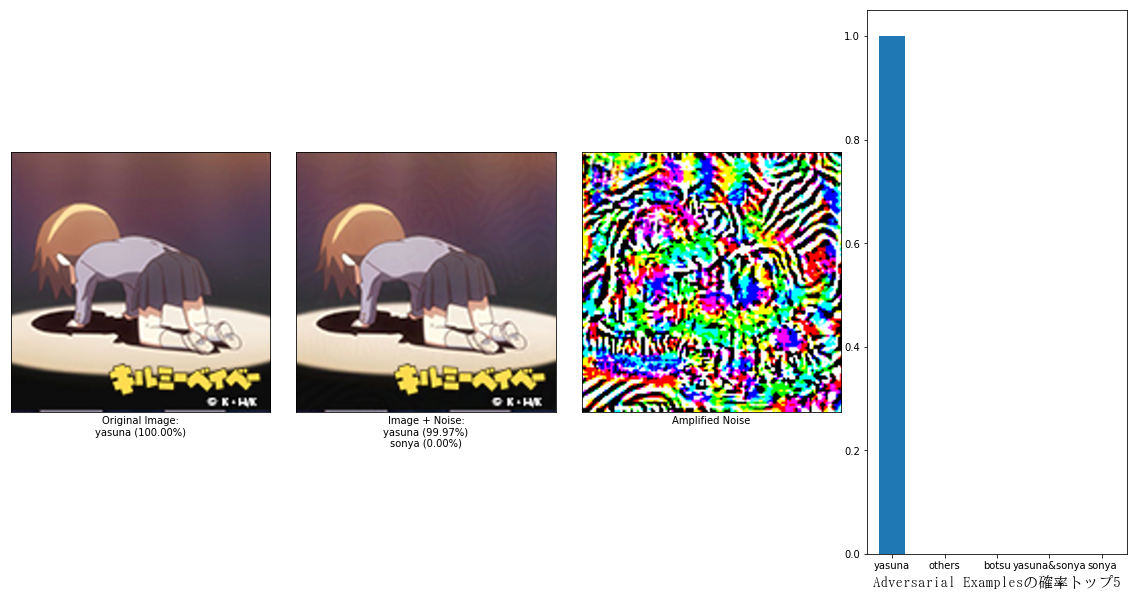

Noise min: -1.200, max: 1.200, mean: -0.002, std: 1.170


In [26]:
img_path = 'kill_me_images/kill_me_baby_datasets/yasuna/01_034.png'
cls_tar = 3

print(class_list[cls_tar])
image_source, adv_img, noise = adversarial_example(img_path=img_path, cls_tar=cls_tar, noise_limit=1.2, required_score=0.99, iterations=1000)

In [27]:
img_path = 'kill_me_images/kill_me_baby_datasets/yasuna/01_033.png'
cls_tar = 0

print(class_list[cls_tar])
image_source, adv_img, noise = adversarial_example(img_path=img_path, cls_tar=cls_tar, noise_limit=1.2, required_score=0.99, iterations=1000)

agiri


FileNotFoundError: [Errno 2] No such file or directory: 'kill_me_images/kill_me_baby_datasets/yasuna/01_033.png'

yasuna
INFO:tensorflow:Restoring parameters from killme_vgg16/killme_vgg16.ckpt
イテレーション： 0
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -6.388824, max:  7.594039, stepsize:      0.92

イテレーション： 1
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.362150, max:  6.208197, stepsize:      1.13

イテレーション： 2
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.162589, max:  7.113407, stepsize:      0.98

イテレーション： 3
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.310479, max:  7.253609, stepsize:      0.97

イテレーション： 4
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gr

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.488118, max:  7.407662, stepsize:      0.94

イテレーション： 43
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.639485, max:  7.376740, stepsize:      0.95

イテレーション： 44
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.499296, max:  7.620093, stepsize:      0.92

イテレーション： 45
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.635337, max:  7.361950, stepsize:      0.95

イテレーション： 46
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.745287, max:  7.551546, stepsize:      0.93

イテレーション： 47
Source score: 1

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.592741, max:  7.595848, stepsize:      0.92

イテレーション： 85
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.627343, max:  7.283992, stepsize:      0.96

イテレーション： 86
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.592053, max:  7.447584, stepsize:      0.94

イテレーション： 87
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.702419, max:  7.563122, stepsize:      0.93

イテレーション： 88
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.598953, max:  7.492557, stepsize:      0.93

イテレーション： 89
Source score: 1

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.761063, max:  7.558934, stepsize:      0.93

イテレーション： 127
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.689997, max:  7.571045, stepsize:      0.92

イテレーション： 128
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.737768, max:  7.743043, stepsize:      0.90

イテレーション： 129
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.568636, max:  7.549181, stepsize:      0.93

イテレーション： 130
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.686749, max:  7.567745, stepsize:      0.92

イテレーション： 131
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.675718, max:  7.621080, stepsize:      0.92

イテレーション： 169
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.631766, max:  7.554963, stepsize:      0.93

イテレーション： 170
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.761933, max:  7.584797, stepsize:      0.92

イテレーション： 171
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.680549, max:  7.584437, stepsize:      0.92

イテレーション： 172
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.751622, max:  7.589347, stepsize:      0.92

イテレーション： 173
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.724314, max:  7.570419, stepsize:      0.92

イテレーション： 211
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.709576, max:  7.766943, stepsize:      0.90

イテレーション： 212
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.691915, max:  7.569923, stepsize:      0.92

イテレーション： 213
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.727517, max:  7.765952, stepsize:      0.90

イテレーション： 214
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.583256, max:  7.572553, stepsize:      0.92

イテレーション： 215
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.681719, max:  7.550844, stepsize:      0.93

イテレーション： 253
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.825283, max:  7.537834, stepsize:      0.93

イテレーション： 254
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.702987, max:  7.575112, stepsize:      0.92

イテレーション： 255
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.817976, max:  7.586371, stepsize:      0.92

イテレーション： 256
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.684013, max:  7.550714, stepsize:      0.93

イテレーション： 257
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.682578, max:  7.595801, stepsize:      0.92

イテレーション： 295
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.825311, max:  7.560802, stepsize:      0.93

イテレーション： 296
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.702870, max:  7.552993, stepsize:      0.93

イテレーション： 297
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.711650, max:  7.526434, stepsize:      0.93

イテレーション： 298
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.673280, max:  7.578205, stepsize:      0.92

イテレーション： 299
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.693507, max:  7.566766, stepsize:      0.93

イテレーション： 337
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.767488, max:  7.526703, stepsize:      0.93

イテレーション： 338
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.698010, max:  7.607924, stepsize:      0.92

イテレーション： 339
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.699317, max:  7.490866, stepsize:      0.93

イテレーション： 340
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.690768, max:  7.592114, stepsize:      0.92

イテレーション： 341
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.718727, max:  7.614784, stepsize:      0.92

イテレーション： 379
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.786760, max:  7.583150, stepsize:      0.92

イテレーション： 380
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.673292, max:  7.609140, stepsize:      0.92

イテレーション： 381
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.751622, max:  7.476164, stepsize:      0.94

イテレーション： 382
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.685963, max:  7.603284, stepsize:      0.92

イテレーション： 383
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.691442, max:  7.602787, stepsize:      0.92

イテレーション： 421
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.826868, max:  7.520895, stepsize:      0.93

イテレーション： 422
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.681201, max:  7.582740, stepsize:      0.92

イテレーション： 423
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.708565, max:  7.602024, stepsize:      0.92

イテレーション： 424
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.694123, max:  7.603705, stepsize:      0.92

イテレーション： 425
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.681406, max:  7.620147, stepsize:      0.92

イテレーション： 463
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.828657, max:  7.589460, stepsize:      0.92

イテレーション： 464
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.708050, max:  7.529918, stepsize:      0.93

イテレーション： 465
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.778025, max:  7.582944, stepsize:      0.92

イテレーション： 466
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.680015, max:  7.627459, stepsize:      0.92

イテレーション： 467
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.682447, max:  7.623988, stepsize:      0.92

イテレーション： 505
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.750473, max:  7.591332, stepsize:      0.92

イテレーション： 506
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.690328, max:  7.612438, stepsize:      0.92

イテレーション： 507
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.786207, max:  7.526843, stepsize:      0.93

イテレーション： 508
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.674528, max:  7.610626, stepsize:      0.92

イテレーション： 509
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.673905, max:  7.586150, stepsize:      0.92

イテレーション： 547
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.740191, max:  7.481349, stepsize:      0.94

イテレーション： 548
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.696177, max:  7.611279, stepsize:      0.92

イテレーション： 549
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.787844, max:  7.592990, stepsize:      0.92

イテレーション： 550
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.711016, max:  7.603601, stepsize:      0.92

イテレーション： 551
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.677348, max:  7.517369, stepsize:      0.93

イテレーション： 589
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.776360, max:  7.622345, stepsize:      0.92

イテレーション： 590
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.709907, max:  7.586895, stepsize:      0.92

イテレーション： 591
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.785086, max:  7.589506, stepsize:      0.92

イテレーション： 592
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.675708, max:  7.598325, stepsize:      0.92

イテレーション： 593
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.710842, max:  7.587773, stepsize:      0.92

イテレーション： 631
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.768605, max:  7.506986, stepsize:      0.93

イテレーション： 632
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.667025, max:  7.589587, stepsize:      0.92

イテレーション： 633
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.689551, max:  7.610171, stepsize:      0.92

イテレーション： 634
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.674378, max:  7.594992, stepsize:      0.92

イテレーション： 635
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.600612, max:  7.538945, stepsize:      0.93

イテレーション： 673
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.689029, max:  7.598302, stepsize:      0.92

イテレーション： 674
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.686437, max:  7.564297, stepsize:      0.93

イテレーション： 675
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.827780, max:  7.596765, stepsize:      0.92

イテレーション： 676
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.694509, max:  7.484197, stepsize:      0.94

イテレーション： 677
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.705113, max:  7.595447, stepsize:      0.92

イテレーション： 715
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.703444, max:  7.619242, stepsize:      0.92

イテレーション： 716
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.674057, max:  7.516526, stepsize:      0.93

イテレーション： 717
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.833076, max:  7.789045, stepsize:      0.90

イテレーション： 718
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.670576, max:  7.593825, stepsize:      0.92

イテレーション： 719
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.669087, max:  7.596302, stepsize:      0.92

イテレーション： 757
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.827375, max:  7.613476, stepsize:      0.92

イテレーション： 758
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.673631, max:  7.509764, stepsize:      0.93

イテレーション： 759
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.733584, max:  7.578950, stepsize:      0.92

イテレーション： 760
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.700809, max:  7.587074, stepsize:      0.92

イテレーション： 761
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.668105, max:  7.591753, stepsize:      0.92

イテレーション： 799
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.833025, max:  7.588435, stepsize:      0.92

イテレーション： 800
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.667675, max:  7.789231, stepsize:      0.90

イテレーション： 801
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.827353, max:  7.500679, stepsize:      0.93

イテレーション： 802
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.690428, max:  7.791753, stepsize:      0.90

イテレーション： 803
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.662744, max:  7.563957, stepsize:      0.93

イテレーション： 841
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.759929, max:  7.769890, stepsize:      0.90

イテレーション： 842
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.684914, max:  7.545935, stepsize:      0.93

イテレーション： 843
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.733265, max:  7.611037, stepsize:      0.92

イテレーション： 844
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.670910, max:  7.483254, stepsize:      0.94

イテレーション： 845
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.669872, max:  7.596868, stepsize:      0.92

イテレーション： 883
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.690852, max:  7.756691, stepsize:      0.90

イテレーション： 884
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.667406, max:  7.592352, stepsize:      0.92

イテレーション： 885
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.819721, max:  7.556189, stepsize:      0.93

イテレーション： 886
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.696830, max:  7.520696, stepsize:      0.93

イテレーション： 887
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.675794, max:  7.621073, stepsize:      0.92

イテレーション： 925
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.815349, max:  7.791408, stepsize:      0.90

イテレーション： 926
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.662391, max:  7.568143, stepsize:      0.92

イテレーション： 927
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.725404, max:  7.595604, stepsize:      0.92

イテレーション： 928
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.678487, max:  7.610403, stepsize:      0.92

イテレーション： 929
Source sco

Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.672736, max:  7.796865, stepsize:      0.90

イテレーション： 967
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.818490, max:  7.532375, stepsize:      0.93

イテレーション： 968
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.689069, max:  7.593276, stepsize:      0.92

イテレーション： 969
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.773530, max:  7.471185, stepsize:      0.94

イテレーション： 970
Source score: 100.00%, class-number:    3, class-name: sonya
Target score:   0.00%, class-number:    4, class-name: yasuna
Gradient min: -5.689807, max:  7.791803, stepsize:      0.90

イテレーション： 971
Source sco

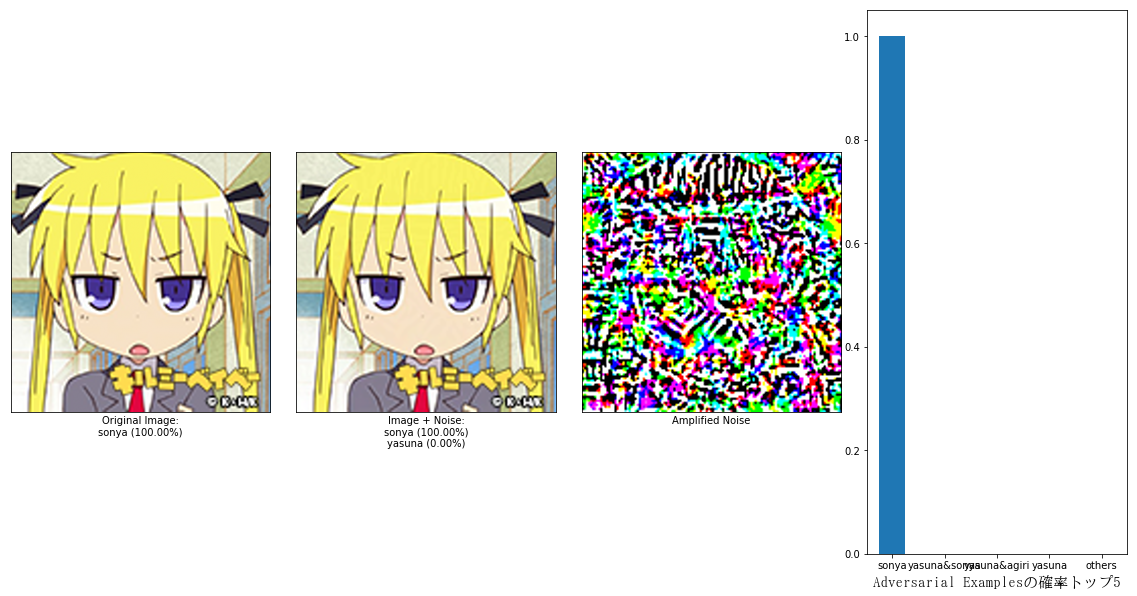

Noise min: -1.200, max: 1.200, mean: -0.004, std: 1.186


In [28]:
img_path = 'kill_me_images/kill_me_baby_datasets/sonya/01_066.png'
cls_tar = 4

print(class_list[cls_tar])
image_source, adv_img, noise = adversarial_example(img_path=img_path, cls_tar=cls_tar, noise_limit=1.2, required_score=0.99, iterations=1000)